# Car Price Prediciton

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from bokeh.plotting import figure, show
from scipy.stats import skew,boxcox
from scipy.special import inv_boxcox
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
sns.set_palette("bright")
%matplotlib inline

In [2]:
# audi_df  = pd.read_csv("https://raw.githubusercontent.com/overtunned/carpriceprediction/main/Dataset/audi.csv")
audi_df  = pd.read_csv("dataset/audi.csv")

In [3]:
audi_df.head()

model  year  price transmission  mileage fuelType  tax   mpg  engineSize
0    A1  2017  12500       Manual    15735   Petrol  150  55.4         1.4
1    A6  2016  16500    Automatic    36203   Diesel   20  64.2         2.0
2    A1  2016  11000       Manual    29946   Petrol   30  55.4         1.4
3    A4  2017  16800    Automatic    25952   Diesel  145  67.3         2.0
4    A3  2019  17300       Manual     1998   Petrol  145  49.6         1.0

### Data Preprocessing

In [4]:
audi_df.describe()

year          price        mileage           tax           mpg  \
count  10668.000000   10668.000000   10668.000000  10668.000000  10668.000000   
mean    2017.100675   22896.685039   24827.244001    126.011436     50.770022   
std        2.167494   11714.841888   23505.257205     67.170294     12.949782   
min     1997.000000    1490.000000       1.000000      0.000000     18.900000   
25%     2016.000000   15130.750000    5968.750000    125.000000     40.900000   
50%     2017.000000   20200.000000   19000.000000    145.000000     49.600000   
75%     2019.000000   27990.000000   36464.500000    145.000000     58.900000   
max     2020.000000  145000.000000  323000.000000    580.000000    188.300000   

         engineSize  
count  10668.000000  
mean       1.930709  
std        0.602957  
min        0.000000  
25%        1.500000  
50%        2.000000  
75%        2.000000  
max        6.300000

In [5]:
audi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10668 entries, 0 to 10667
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10668 non-null  object 
 1   year          10668 non-null  int64  
 2   price         10668 non-null  int64  
 3   transmission  10668 non-null  object 
 4   mileage       10668 non-null  int64  
 5   fuelType      10668 non-null  object 
 6   tax           10668 non-null  int64  
 7   mpg           10668 non-null  float64
 8   engineSize    10668 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 750.2+ KB


In [6]:
audi_df.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

In [7]:
audi_df.dtypes

model            object
year              int64
price             int64
transmission     object
mileage           int64
fuelType         object
tax               int64
mpg             float64
engineSize      float64
dtype: object

In [8]:
# dropping tax as i dont know what it is based on.
audi_df = audi_df.drop("tax",axis=1)

In [9]:
missing = audi_df.loc[audi_df.engineSize == 0].index
audi_df.loc[missing, 'engineSize'] = audi_df["engineSize"].median()

Filling the missing values with median of that attribute

There is a high negative correlation between price and mpg and mileage.

<AxesSubplot:xlabel='model', ylabel='Count'>

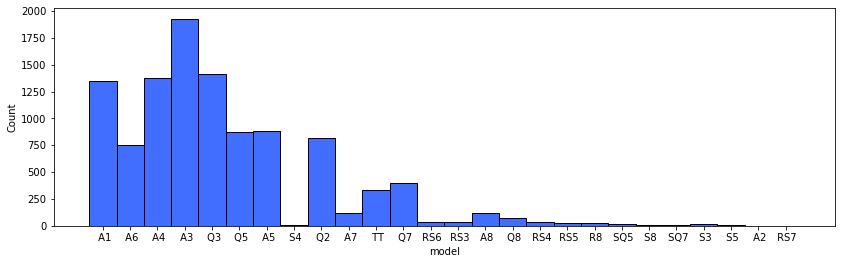

In [10]:
fig_dims = (14, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.histplot(audi_df.model,ax=ax)

<AxesSubplot:xlabel='transmission', ylabel='Count'>

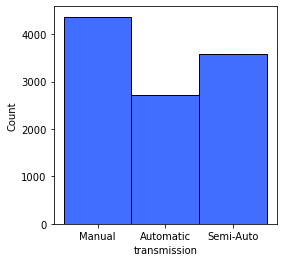

In [11]:
fig_dims = (4, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.histplot(audi_df.transmission,ax=ax)

<AxesSubplot:xlabel='fuelType', ylabel='Count'>

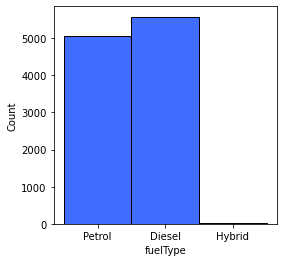

In [12]:
fig_dims = (4, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.histplot(audi_df.fuelType,ax=ax)

In [13]:
price_year = pd.DataFrame(audi_df[['year','price']].groupby('year').mean())
px.line(price_year)

Price of cars have been on the rise as the years goes by. At present, it is now at the peak of all previous year prices

In [14]:
px.scatter(audi_df,x='mileage', y = 'price')

From the above graph we can see that the price of the car decreases as the distance the car was used for increases. No car is priced more than 20k after a distance of 100k, 

In [15]:
price_mpg = pd.DataFrame(audi_df[['mpg','price']].groupby('mpg').mean())
px.scatter(price_mpg)

From the graph we can see that the value of cars having price above 50k all have a mpg below 30 which is a foot into luxuary.

In [16]:
price_engine0to2= audi_df[audi_df.engineSize<=2].price.mean()
price_engine2to4 = audi_df[(audi_df.engineSize>2) & (audi_df.engineSize<=4)].price.mean()
price_engine4to6 = audi_df[(audi_df.engineSize>4) & (audi_df.engineSize<=6)].price.mean()
plot_df = pd.DataFrame([price_engine0to2,price_engine2to4, price_engine4to6], columns=["Price_mean"],index=["engineSize0to2","engineSize2to4","engineSize4to6"])
px.bar(plot_df)

We can see that the price of a car increases as the size of the engine it uses increases.

In [17]:
mpg_engine0to2= audi_df[audi_df.engineSize<=2].mpg.mean()
mpg_engine2to4 = audi_df[(audi_df.engineSize>2) & (audi_df.engineSize<=4)].mpg.mean()
mpg_engine4to6 = audi_df[(audi_df.engineSize>2) & (audi_df.engineSize<=6)].mpg.mean()
plot_df = pd.DataFrame([mpg_engine0to2,mpg_engine2to4,mpg_engine4to6], columns=["mileage"],index=["engineSize 0 to 2","engineSize 2 to 4","engineSize 4 to 6"])
px.bar(plot_df)

The miles per gallon of the car decreases as the size of the engine increases. This is becauses it takes more fuel to power a bigger engine than a smaller one. Hence the decreases in the mpg.

### Feature Engineering

In [18]:
cat_df = audi_df[["year","model","fuelType","transmission"]].astype('category').copy()
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10668 entries, 0 to 10667
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          10668 non-null  category
 1   model         10668 non-null  category
 2   fuelType      10668 non-null  category
 3   transmission  10668 non-null  category
dtypes: category(4)
memory usage: 44.2 KB


In [19]:
num_df = audi_df[['price','mileage', 'mpg','engineSize']].copy()

<AxesSubplot:>

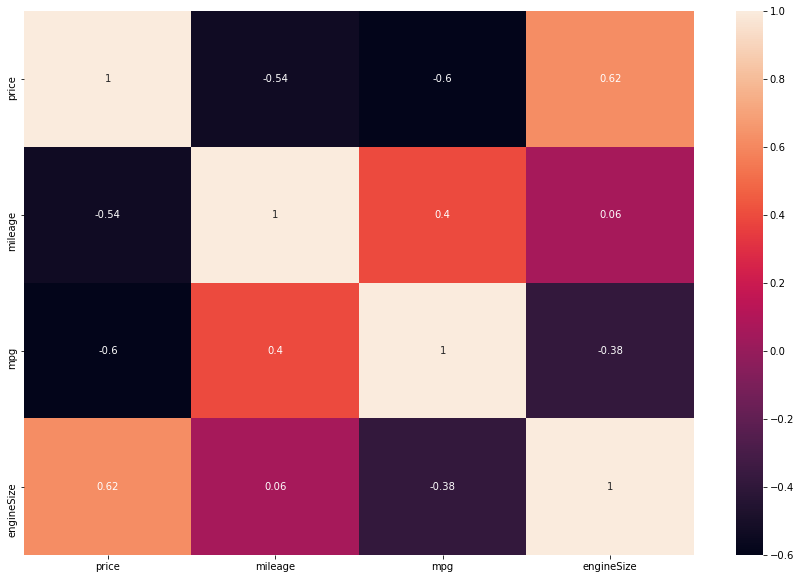

In [20]:
plt.figure(figsize = (15,10))
sns.heatmap(num_df.corr(),annot = True)

In [21]:
print("Boxcox\t\tSkew\t\t\t\tTransformed")
for i in num_df.columns:
    print("{}\t->\t{}\t->\t{}".format(i,skew(num_df[i].values),skew(boxcox(num_df[i].values)[0])))
print("Log")
for i in num_df.columns:
    print("{}\t->\t{}\t->\t{}".format(i,skew(num_df[i].values),skew(np.log1p(num_df[i].values))))

Boxcox		Skew				Transformed
price	->	2.2770028653255587	->	0.00872825516975382
mileage	->	1.5762072303535488	->	-0.09015078408269933
mpg	->	1.832601611204326	->	-0.0031723653871693867
engineSize	->	1.4562119598170369	->	-0.01327721253130936
Log
price	->	2.2770028653255587	->	-0.11472900871680033
mileage	->	1.5762072303535488	->	-1.808948759781167
mpg	->	1.832601611204326	->	0.06843022609659101
engineSize	->	1.4562119598170369	->	0.6190036858008828


In [22]:
price_lam = boxcox(num_df["price"])[1] # for transforming back the values

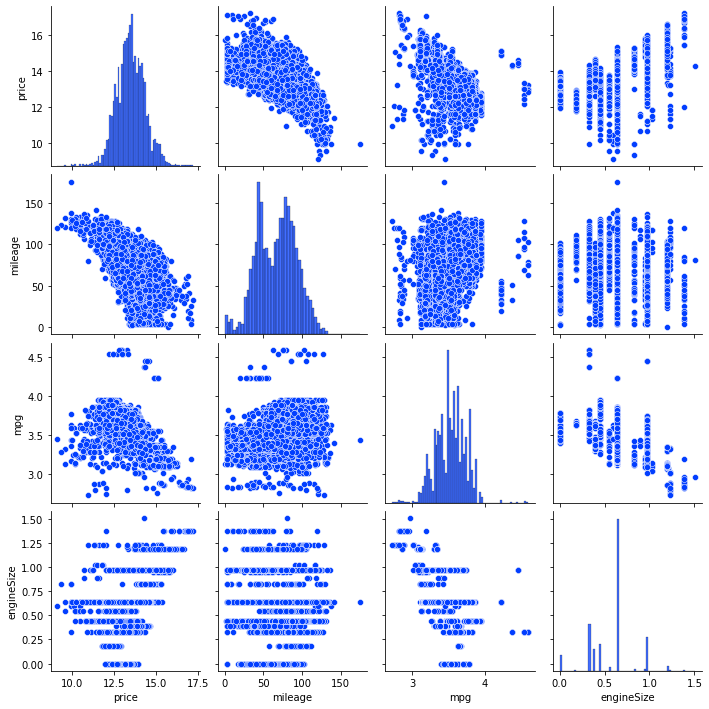

In [23]:
num_df = num_df.apply(lambda x : boxcox(x)[0])
sns.pairplot(num_df)

In [24]:
norm_df = num_df.apply(scale)

In [25]:
df = pd.concat([cat_df,norm_df], axis = 1)
df

year model fuelType transmission     price   mileage       mpg  \
0      2017    A1   Petrol       Manual -1.049892 -0.081347  0.486385   
1      2016    A6   Diesel    Automatic -0.472004  0.733695  1.086509   
2      2016    A1   Petrol       Manual -1.312827  0.528629  0.486385   
3      2017    A4   Diesel    Automatic -0.434172  0.381925  1.277516   
4      2019    A3   Petrol       Manual -0.372510 -1.372938  0.033214   
...     ...   ...      ...          ...       ...       ...       ...   
10663  2020    A3   Petrol       Manual -0.409426 -1.026709  0.033214   
10664  2020    A3   Petrol       Manual -0.409426 -1.377382  0.033214   
10665  2020    A3   Petrol       Manual -0.384829 -1.810562  0.033214   
10666  2017    Q3   Petrol    Automatic -0.119826 -0.546903 -0.110233   
10667  2016    Q3   Petrol       Manual -0.536651 -0.312567 -0.110233   

       engineSize  
0       -1.022235  
1        0.280494  
2       -1.022235  
3        0.280494  
4       -2.349542  
...           ...  
10663   -2.349542  
10664   -2.349542  
10665   -2.349542  
10666   -1.022235  
10667   -1.022235  

[10668 rows x 8 columns]

In [26]:
final_df = pd.get_dummies(df, prefix_sep="_", drop_first=True)

In [27]:
final_df.head()

price   mileage       mpg  engineSize  year_1998  year_2002  year_2003  \
0 -1.049892 -0.081347  0.486385   -1.022235          0          0          0   
1 -0.472004  0.733695  1.086509    0.280494          0          0          0   
2 -1.312827  0.528629  0.486385   -1.022235          0          0          0   
3 -0.434172  0.381925  1.277516    0.280494          0          0          0   
4 -0.372510 -1.372938  0.033214   -2.349542          0          0          0   

   year_2004  year_2005  year_2006  ...  model_ S4  model_ S5  model_ S8  \
0          0          0          0  ...          0          0          0   
1          0          0          0  ...          0          0          0   
2          0          0          0  ...          0          0          0   
3          0          0          0  ...          0          0          0   
4          0          0          0  ...          0          0          0   

   model_ SQ5  model_ SQ7  model_ TT  fuelType_Hybrid  fuelType_Petrol  \
0           0           0          0                0                1   
1           0           0          0                0                0   
2           0           0          0                0                1   
3           0           0          0                0                0   
4           0           0          0                0                1   

   transmission_Manual  transmission_Semi-Auto  
0                    1                       0  
1                    0                       0  
2                    1                       0  
3                    0                       0  
4                    1                       0  

[5 rows x 53 columns]

In [28]:
X = final_df.iloc[:,1:]
y = final_df.iloc[:,0]

In [29]:
pcs = PCA(.90)
pcs.fit(X)
pcs.explained_variance_ratio_

array([0.34418352, 0.21911   , 0.08705647, 0.05532716, 0.0355964 ,
       0.03139667, 0.02791095, 0.02499574, 0.0224722 , 0.01960117,
       0.01766445, 0.01556876])

In [30]:
pcsSummary = pd.DataFrame({"Standard deviation":np.sqrt(pcs.explained_variance_),"Proportion of variance": pcs.explained_variance_ratio_,
"Cumulative proportion": np.cumsum(pcs.explained_variance_ratio_)})
pcsSummary

Standard deviation  Proportion of variance  Cumulative proportion
0             1.352901                0.344184               0.344184
1             1.079449                0.219110               0.563294
2             0.680412                0.087056               0.650350
3             0.542426                0.055327               0.705677
4             0.435085                0.035596               0.741274
5             0.408614                0.031397               0.772670
6             0.385264                0.027911               0.800581
7             0.364589                0.024996               0.825577
8             0.345696                0.022472               0.848049
9             0.322858                0.019601               0.867650
10            0.306493                0.017664               0.885315
11            0.287739                0.015569               0.900883

In [31]:
pcs_df = pd.DataFrame(pcs.transform(X))
pcs_df.columns = ["PC{}".format(i) for i in range(1,len(pcs_df.columns)+1)]
pcs_df

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0     -0.905500 -1.011636 -0.287608 -0.152463  0.861157 -0.006426  0.053521   
1     -1.101750  0.898649  0.605381  0.126042 -0.480218  0.471312 -0.018616   
2     -1.256631 -0.611949 -0.571139 -0.320732 -0.344706  0.654368  0.235307   
3     -1.024448  0.625384  0.872165  0.246974  0.908288 -0.036896 -0.142341   
4     -0.253182 -2.918669  0.004735 -0.321750 -0.468393 -0.561002  0.274486   
...         ...       ...       ...       ...       ...       ...       ...   
10663 -0.584878 -2.614142 -0.315791 -0.114994 -0.075944 -0.036605  0.699238   
10664 -0.401324 -2.806453 -0.128556 -0.117346 -0.025892  0.016612  0.766382   
10665 -0.174584 -3.044012  0.102732 -0.120251  0.035937  0.082350  0.849324   
10666 -0.041724 -1.164944 -0.420857  0.280614  0.787935  0.211053 -0.367076   
10667 -0.397322 -1.088417 -0.548739 -0.469367 -0.227985  1.016359  0.009107   

            PC8       PC9      PC10      PC11      PC12  
0     -0.002776 -0.226992 -0.228109 -0.026923 -0.087998  
1     -0.080593 -0.252497 -0.482876  0.296018  0.128118  
2     -0.134929 -0.183608 -0.258060  0.072321 -0.069852  
3     -0.629568 -0.250162  0.300378 -0.030549 -0.161261  
4      0.016211 -0.120908  0.143972 -0.114382 -0.060071  
...         ...       ...       ...       ...       ...  
10663  0.435934  0.395442  0.074613 -0.404415 -0.378412  
10664  0.467636  0.408205  0.075727 -0.397289 -0.389201  
10665  0.506798  0.423970  0.077103 -0.388486 -0.402529  
10666  0.480971 -0.460173  0.171630  0.331453 -0.087196  
10667  0.519193 -0.379228  0.210481  0.181721  0.020628  

[10668 rows x 12 columns]

We can see that we need atleast 20 columns to retain 90 percent of the variance.

In [32]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = .30, random_state = 1)
X_trainpca,X_testpca,y_train,y_test = train_test_split(pcs_df,y,test_size = .30, random_state = 1)

In [33]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from sklearn.model_selection import KFold, RepeatedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report,auc,mean_squared_error

In [34]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [35]:
regressionSummary(y_train,lm.predict(X_train))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.2550
            Mean Absolute Error (MAE) : 0.1963
          Mean Percentage Error (MPE) : -1.5355
Mean Absolute Percentage Error (MAPE) : 95.9140


In [36]:
regressionSummary(y_test,lm.predict(X_test))


Regression statistics

                      Mean Error (ME) : -0.0042
       Root Mean Squared Error (RMSE) : 0.2595
            Mean Absolute Error (MAE) : 0.1978
          Mean Percentage Error (MPE) : -2.6621
Mean Absolute Percentage Error (MAPE) : 98.8171


In [37]:
lm_pca = LinearRegression()
lm_pca.fit(X_trainpca, y_train)

LinearRegression()

In [38]:
regressionSummary(y_train,lm_pca.predict(X_trainpca))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 0.4562
            Mean Absolute Error (MAE) : 0.3253
          Mean Percentage Error (MPE) : -17.7850
Mean Absolute Percentage Error (MAPE) : 138.0412


In [39]:
regressionSummary(y_test,lm_pca.predict(X_testpca))


Regression statistics

                      Mean Error (ME) : -0.0022
       Root Mean Squared Error (RMSE) : 0.4469
            Mean Absolute Error (MAE) : 0.3166
          Mean Percentage Error (MPE) : -9.2092
Mean Absolute Percentage Error (MAPE) : 140.9431


In [40]:
labelencoder = LabelEncoder()
y_class = labelencoder.fit_transform(pd.cut(final_df['price'],2, retbins = True)[0])
labelencoder.classes_

array([Interval(-5.188, -0.393, closed='right'),
       Interval(-0.393, 4.392, closed='right')], dtype=object)

In [41]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y_class,test_size = .30, random_state = 1)
X_trainpca,X_testpca,y_train,y_test = train_test_split(pcs_df,y_class,test_size = .30, random_state = 1)

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [43]:
def kfoldcv(model,X,y):
    cv = KFold(n_splits=10,shuffle=True, random_state=1)
    n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    print("{:.3} accuracy with a standard deviation of {:.3}" .format(n_scores.mean(), n_scores.std()))

In [44]:
def roc_plot(y_test,y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    fig = plt.figure(figsize=(15,15))
    ax=plt.subplot(2,2,1)
    ax.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.6f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC')
    ax.legend(loc="lower right")

In [45]:
results = []
for k in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    results.append({'k': k,'accuracy': accuracy_score(y_test, knn.predict(X_test))})
results = pd.DataFrame(results)
results

k  accuracy
0    1  0.929709
1    2  0.927523
2    3  0.937207
3    4  0.932521
4    5  0.934083
5    6  0.930647
6    7  0.933146
7    8  0.929709
8    9  0.931584
9   10  0.930022
10  11  0.930959
11  12  0.931896
12  13  0.930022
13  14  0.929709

The k values of 3 gives the best solution so takin k as 3 itself.

In [46]:
knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
accuracy_score(y_test, knn.predict(X_test))

0.9372071227741331

In [47]:
kfoldcv(knn,X,y_class)

0.932 accuracy with a standard deviation of 0.00908


<AxesSubplot:>

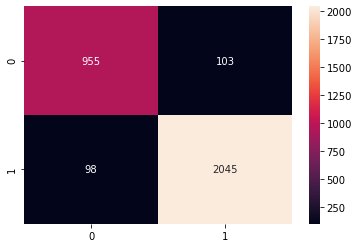

In [48]:
y_pred=knn.predict(X_test)
confusion_matrix(y_test,y_pred)
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt='.4g')

In [49]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1053
           1       0.95      0.95      0.95      2148

    accuracy                           0.94      3201
   macro avg       0.93      0.93      0.93      3201
weighted avg       0.94      0.94      0.94      3201



<Figure size 432x288 with 0 Axes>

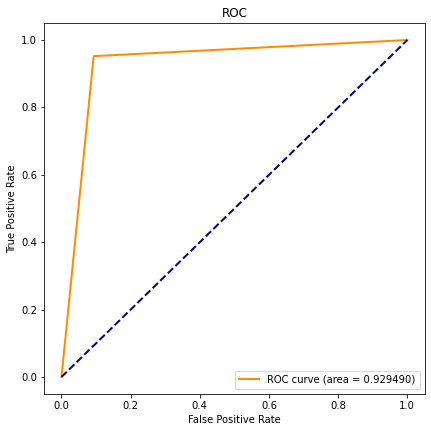

In [50]:
roc_plot(y_pred, y_test)

In [51]:
results = []
for k in range(1, 15):
    knnpca = KNeighborsClassifier(n_neighbors=k).fit(X_trainpca, y_train)
    results.append({'k': k,'accuracy': accuracy_score(y_test, knnpca.predict(X_testpca))})
results = pd.DataFrame(results)
results

k  accuracy
0    1  0.927210
1    2  0.926585
2    3  0.936895
3    4  0.930959
4    5  0.934083
5    6  0.930334
6    7  0.931271
7    8  0.931271
8    9  0.931271
9   10  0.930647
10  11  0.933146
11  12  0.929397
12  13  0.931584
13  14  0.928147

In [52]:
knnpca = KNeighborsClassifier(n_neighbors=3).fit(X_trainpca, y_train)
accuracy_score(y_test, knnpca.predict(X_testpca))

0.9368947203998751

In [53]:
kfoldcv(knnpca,pcs_df,y_class)

0.932 accuracy with a standard deviation of 0.00795


<AxesSubplot:>

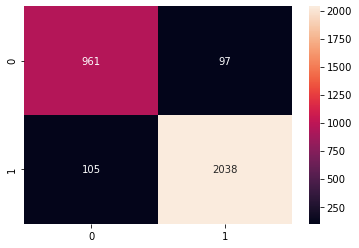

In [54]:
y_pred=knnpca.predict(X_testpca)
confusion_matrix(y_test,y_pred)
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt='.4g')

In [55]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1066
           1       0.95      0.95      0.95      2135

    accuracy                           0.94      3201
   macro avg       0.93      0.93      0.93      3201
weighted avg       0.94      0.94      0.94      3201



<Figure size 432x288 with 0 Axes>

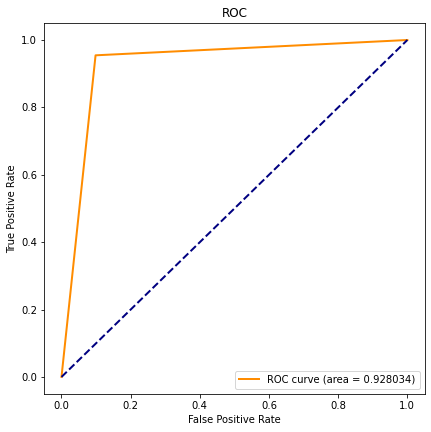

In [56]:
roc_plot(y_pred, y_test)

In [57]:
final_df['price_class'] = y_class

### Student's t-Test
* This is done when we have small amount data to sample from but i have a large observation of 10000+. Here just to take an example im going to sample a small amount of my observation do the t-test
- We are going to take the a small population of engine size of the dataset to do t-test

In [58]:
from scipy import stats

In [59]:
data=final_df[['engineSize', 'price_class']]
sample = np.random.choice(data['engineSize'],30)
sample

array([-1.02223502,  0.28049374,  1.64126425, -1.02223502,  0.28049374,
        0.28049374, -0.7621229 ,  0.28049374,  1.64126425, -2.34954249,
       -0.52238859, -1.02223502,  0.28049374,  0.28049374,  0.28049374,
       -1.02223502, -0.52238859,  0.28049374, -0.09363949, -0.52238859,
        0.28049374, -2.34954249,  0.28049374,  0.28049374,  0.28049374,
        0.28049374,  0.28049374,  0.28049374, -0.7621229 ,  0.28049374])

In [60]:
sample.mean()

-0.14008825925378612

In [61]:
S_A =np.random.choice(data['engineSize'][data['price_class']== 0],10)
S_A.mean()

-0.01166116008681779

In [62]:
S_B =np.random.choice(data['engineSize'][data['price_class']== 1],10)
S_B.mean()

0.5566254399913044

In [63]:
ttest,p_value=stats.ttest_ind(S_A,S_B)
print("P-value = ",p_value)
print("t statastics = " , ttest)

P-value =  0.19853360958083244
t statastics =  -1.3349467558951675


In [64]:
if p_value < 0.05: 
    print(" we are rejecting null hypothesis")
else:
    print("we are accepting null hypothesis")

we are accepting null hypothesis


hence,there is a difference between the engine sizes of cars in price class 0 and price class 1.